In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# this allows us to import from the src folder
SRC = Path("__file__").resolve().parents[1]
if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

import config as cfg

sns.set_theme(style="whitegrid")

In [36]:
# load the final dataset from the 'final/aq_traffic' directory
final_data_path = cfg.FIN_MERGED / "model_ready_dataset.parquet"
print(f"Loading final dataset from: {final_data_path}")

try:
    df = pd.read_parquet(final_data_path)
    print("Dataset loaded successfully.")
    print(f"Shape of the dataset: {df.shape}")
except FileNotFoundError:
    print(f"ERROR: The file {final_data_path.name} was not found. Please run build_model_dataset.py first.")

Loading final dataset from: C:\Air pollution london\data\final\aq_traffic\model_ready_dataset.parquet
Dataset loaded successfully.
Shape of the dataset: (1178823, 47)


In [38]:
print("--- Dataframe Info ---")
df.info()

print("\n--- Statistical Summary ---")
print(df.describe().to_string())

--- Dataframe Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178823 entries, 0 to 1178822
Data columns (total 47 columns):
 #   Column                Non-Null Count    Dtype                        
---  ------                --------------    -----                        
 0   SiteID                1178823 non-null  object                       
 1   date                  1178823 non-null  datetime64[ns, Europe/London]
 2   NO2                   1143018 non-null  float64                      
 3   PM2.5                 936941 non-null   float64                      
 4   temperature_2m        1178823 non-null  float64                      
 5   relative_humidity_2m  1178823 non-null  float64                      
 6   dew_point_2m          1178823 non-null  float64                      
 7   precipitation         1178823 non-null  float64                      
 8   snow_depth            1178823 non-null  float64                      
 9   pressure_msl          1178823 non-

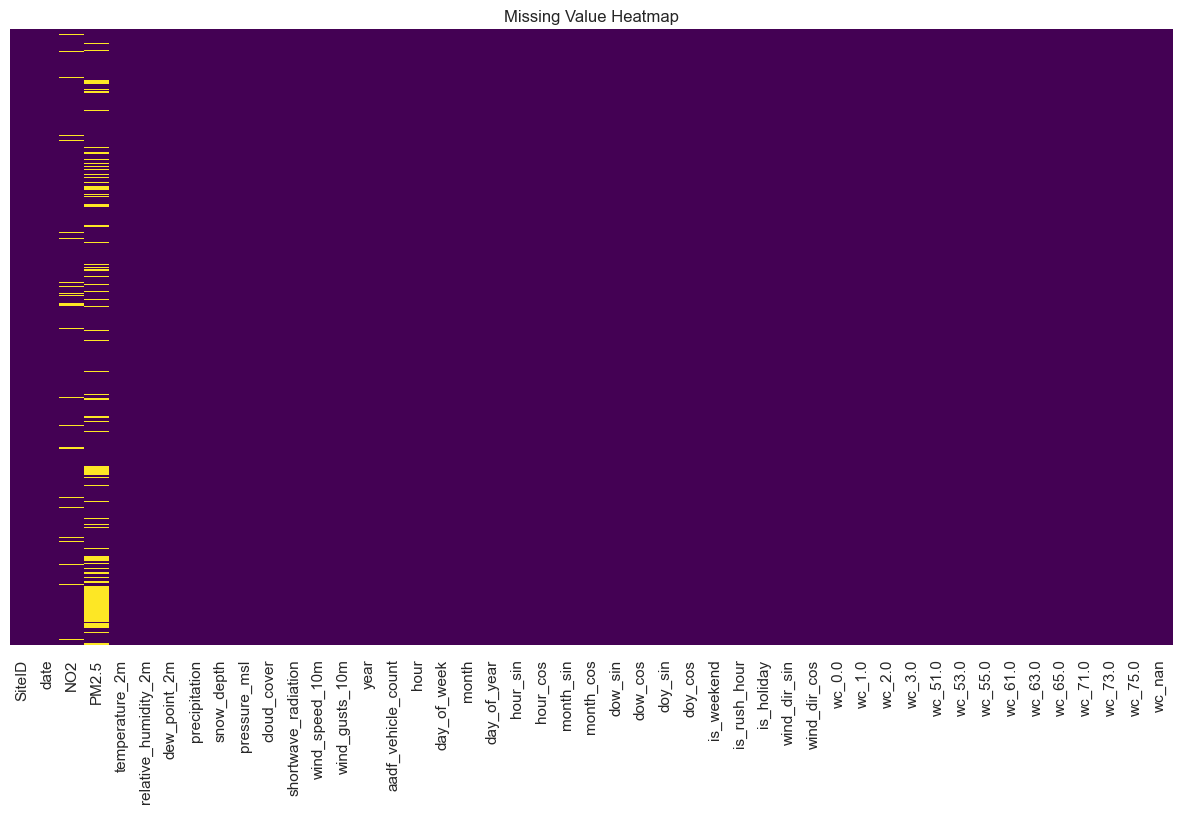


Percentage of missing values per column:
PM2.5    20.518941
NO2       3.037352
dtype: float64


In [46]:
# heatmap to visualize the pattern of missing data
plt.figure(figsize=(15, 8))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.show()

# also print the percentages
missing_percent = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print("\nPercentage of missing values per column:")
print(missing_percent[missing_percent > 0])

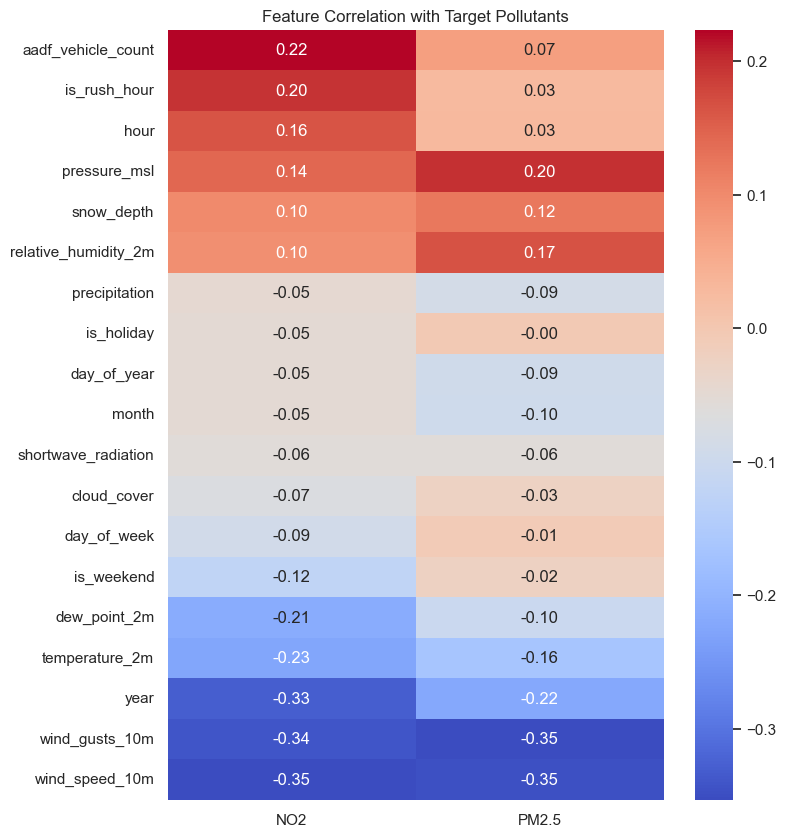

In [58]:
# Correlation Heatmap

# select only the numeric columns for the correlation calculation
numeric_df = df.select_dtypes(include=np.number)

# define the cyclical and redundant columns we want to exclude from this specific plot
cols_to_exclude = [col for col in numeric_df.columns if '_sin' in col or '_cos' in col]
# also exclude the one-hot encoded weather codes from this heatmap
cols_to_exclude += [col for col in numeric_df.columns if 'wc_' in col]

# calculate the correlation matrix on the simplified feature set
corr_matrix_simple = numeric_df.drop(columns=cols_to_exclude).corr()

# isolate the correlations with our target variables
target_corr = corr_matrix_simple[['NO2', 'PM2.5']].drop(['NO2', 'PM2.5'])

# create the heatmap
plt.figure(figsize=(8, 10))
sns.heatmap(
    target_corr.sort_values(by='NO2', ascending=False), 
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
plt.title('Feature Correlation with Target Pollutants')
plt.show()

calculating average no2 for each weather condition...


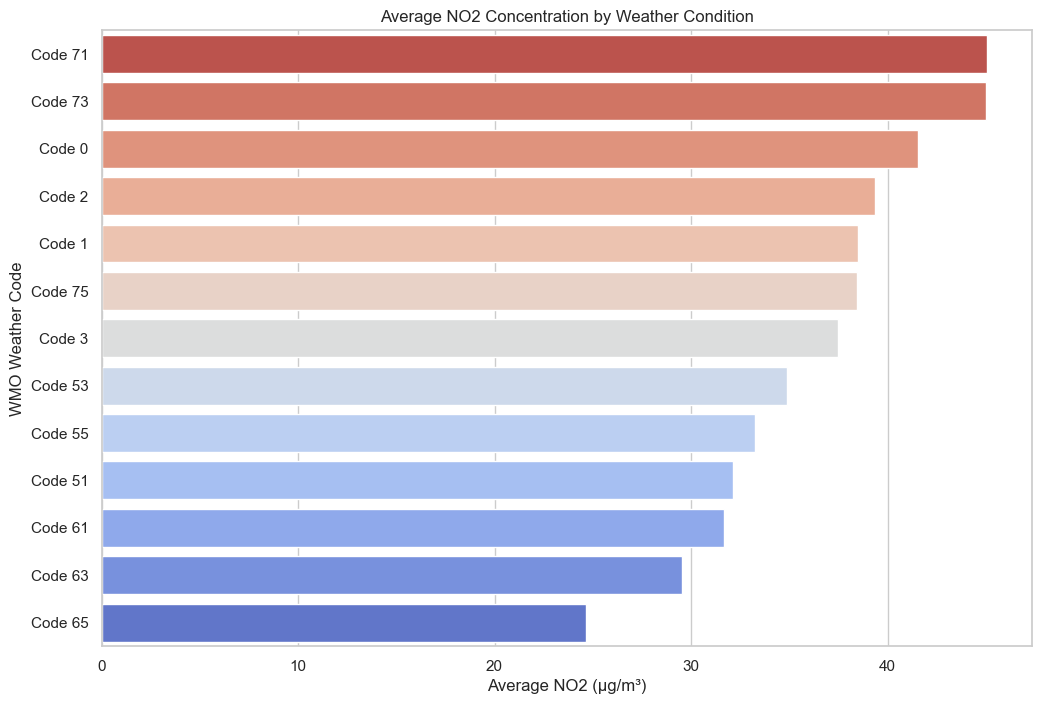


--- WMO Weather Code Reference Table ---
 WMO Code           Description
        0             Clear sky
        1          Mainly clear
        2         Partly cloudy
        3              Overcast
       45                   Fog
       48   Depositing rime fog
       51         Light Drizzle
       53      Moderate Drizzle
       55         Dense Drizzle
       61           Slight Rain
       63         Moderate Rain
       65            Heavy Rain
       71      Slight Snow fall
       73    Moderate Snow fall
       75       Heavy Snow fall
       80   Slight Rain showers
       81 Moderate Rain showers
       82  Violent Rain showers
       95          Thunderstorm


In [73]:
# Impact of Weather Conditions

print("calculating average no2 for each weather condition...")

# find all the one-hot encoded weather code columns
wc_cols = [col for col in df.columns if 'wc_' in col and 'wc_nan' not in col]

# calculate the mean NO2 for when each weather condition is true (== 1)
weather_impact = {}
for col in wc_cols:
    # the weather code number is between the 'wc_' and the '.0'
    weather_condition_code = int(float(col.split('_')[1]))
    mean_no2 = df[df[col] == 1]['NO2'].mean()
    weather_impact[weather_condition_code] = mean_no2

# convert to a pandas Series for easy plotting
impact_series = pd.Series(weather_impact).sort_values(ascending=False)
# format the index for better plot labels
impact_series.index = [f"Code {idx}" for idx in impact_series.index]


# create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=impact_series.values, y=impact_series.index, hue=impact_series.index, palette='coolwarm_r', legend=False)
plt.title('Average NO2 Concentration by Weather Condition')
plt.xlabel('Average NO2 (µg/m³)')
plt.ylabel('WMO Weather Code')
plt.show()

wmo_code_definitions = {
    0: 'Clear sky',
    1: 'Mainly clear',
    2: 'Partly cloudy',
    3: 'Overcast',
    45: 'Fog',
    48: 'Depositing rime fog',
    51: 'Light Drizzle',
    53: 'Moderate Drizzle',
    55: 'Dense Drizzle',
    61: 'Slight Rain',
    63: 'Moderate Rain',
    65: 'Heavy Rain',
    71: 'Slight Snow fall',
    73: 'Moderate Snow fall',
    75: 'Heavy Snow fall',
    80: 'Slight Rain showers',
    81: 'Moderate Rain showers',
    82: 'Violent Rain showers',
    95: 'Thunderstorm'
}

wmo_df = pd.DataFrame(list(wmo_code_definitions.items()), columns=['WMO Code', 'Description'])

print("\n--- WMO Weather Code Reference Table ---")
print(wmo_df.to_string(index=False))

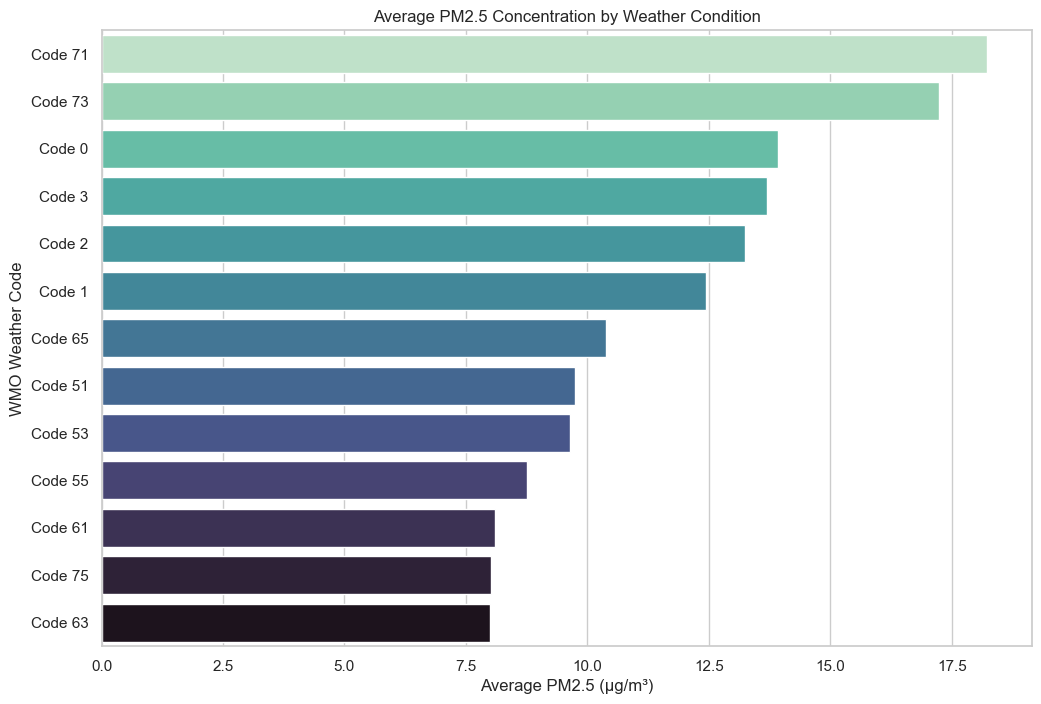


--- WMO Weather Code Reference Table ---
 WMO Code           Description
        0             Clear sky
        1          Mainly clear
        2         Partly cloudy
        3              Overcast
       45                   Fog
       48   Depositing rime fog
       51         Light Drizzle
       53      Moderate Drizzle
       55         Dense Drizzle
       61           Slight Rain
       63         Moderate Rain
       65            Heavy Rain
       71      Slight Snow fall
       73    Moderate Snow fall
       75       Heavy Snow fall
       80   Slight Rain showers
       81 Moderate Rain showers
       82  Violent Rain showers
       95          Thunderstorm


In [71]:
# Impact of Weather Conditions on PM2.5

# find all the one-hot encoded weather code columns
wc_cols = [col for col in df.columns if 'wc_' in col and 'wc_nan' not in col]

# calculate the mean pm2.5 for when each weather condition is true
weather_impact_pm25 = {}
for col in wc_cols:
    weather_condition_code = int(float(col.split('_')[1]))
    mean_pm25 = df[df[col] == 1]['PM2.5'].mean()
    weather_impact_pm25[f"Code {weather_condition_code}"] = mean_pm25

# convert to a pandas Series for easy plotting
impact_series_pm25 = pd.Series(weather_impact_pm25).sort_values(ascending=False)

# create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=impact_series_pm25.values, y=impact_series_pm25.index, hue=impact_series_pm25.index, palette='mako_r', legend=False)
plt.title('Average PM2.5 Concentration by Weather Condition')
plt.xlabel('Average PM2.5 (µg/m³)')
plt.ylabel('WMO Weather Code')
plt.show()

print("\n--- WMO Weather Code Reference Table ---")
print(wmo_df.to_string(index=False))

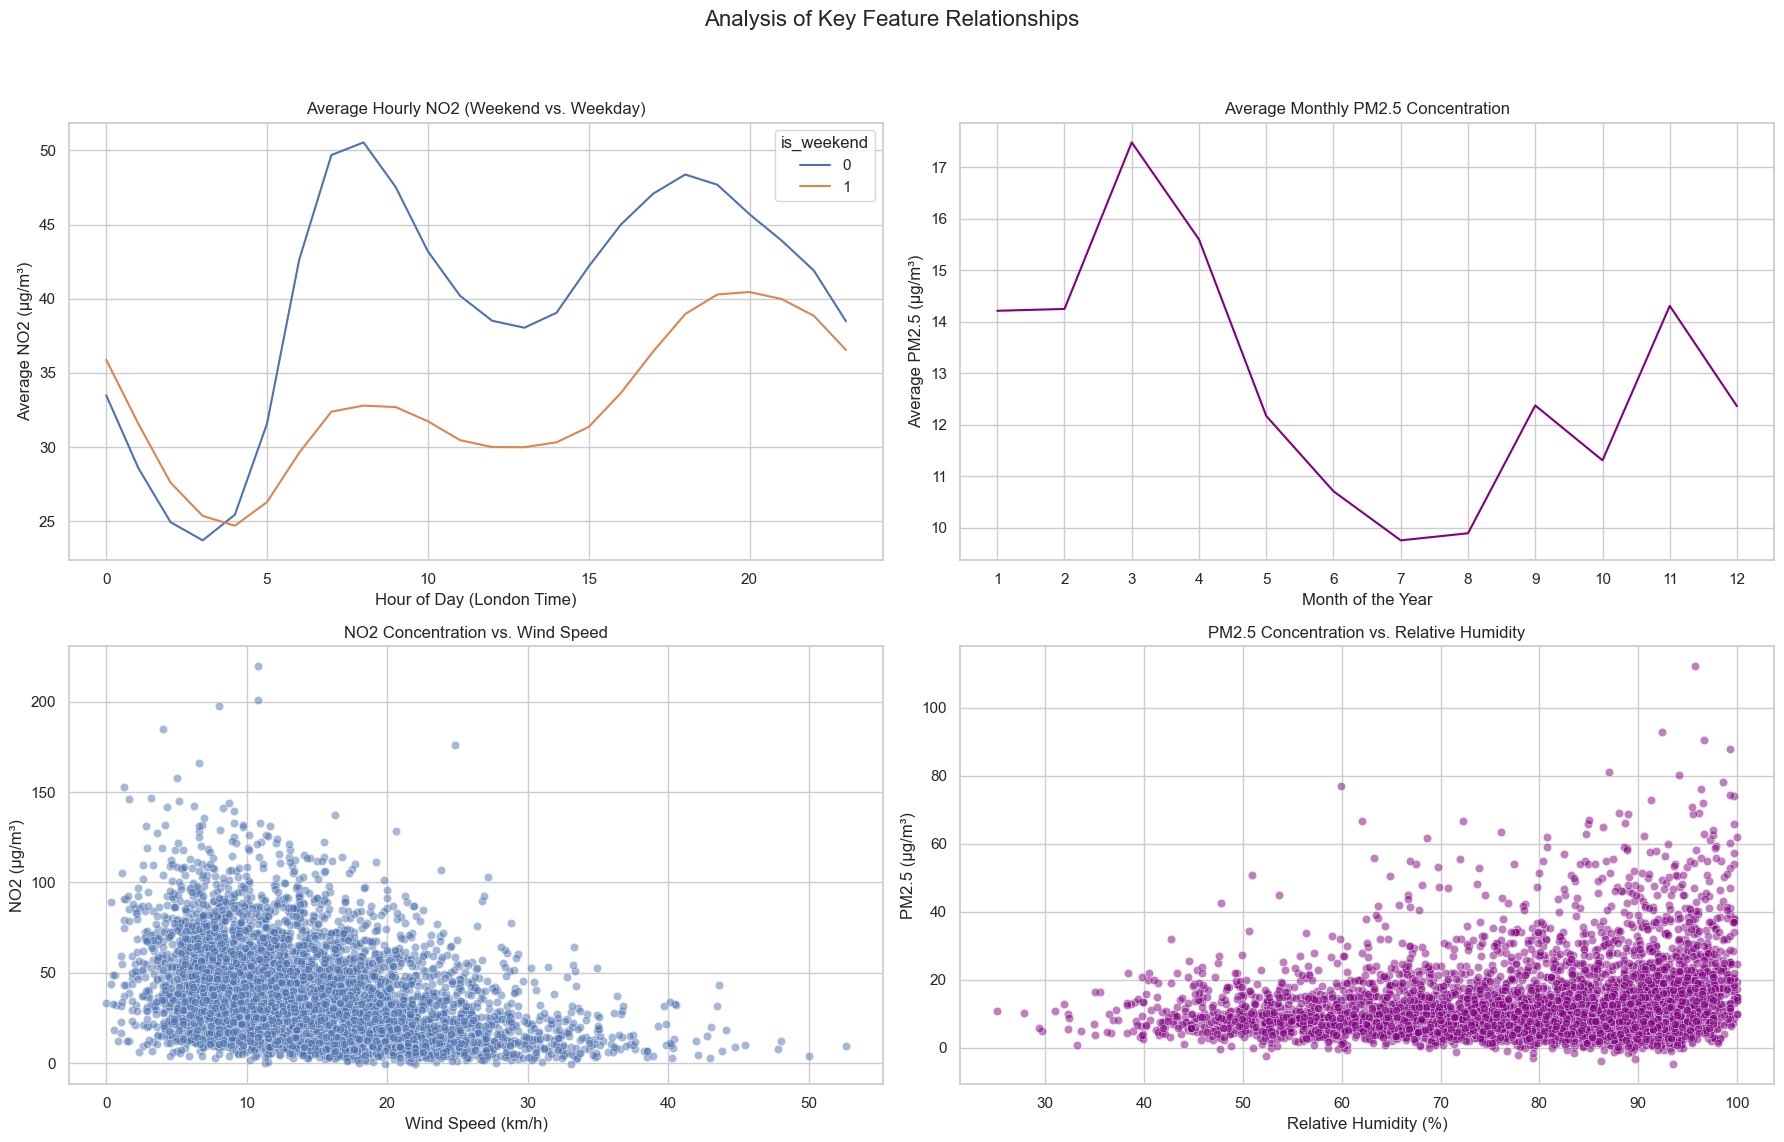

In [52]:
# create a sample for scatter plots to keep them readable
df_sample = df.dropna(subset=['NO2', 'PM2.5']).sample(n=5000, random_state=42)

# setup the plot grid
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Analysis of Key Feature Relationships', fontsize=16)

# 1. hourly pattern of no2 - using the original 'hour' column
sns.lineplot(data=df, x='hour', y='NO2', hue='is_weekend', ax=axes[0, 0], errorbar=None)
axes[0, 0].set_title('Average Hourly NO2 (Weekend vs. Weekday)')
axes[0, 0].set_xlabel('Hour of Day (London Time)')
axes[0, 0].set_ylabel('Average NO2 (µg/m³)')
axes[0, 0].grid(True)

# 2. seasonal (monthly) pattern of pm2.5 - using the original 'month' column
sns.lineplot(data=df, x='month', y='PM2.5', ax=axes[0, 1], errorbar=None, color='purple')
axes[0, 1].set_title('Average Monthly PM2.5 Concentration')
axes[0, 1].set_xlabel('Month of the Year')
axes[0, 1].set_ylabel('Average PM2.5 (µg/m³)')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].grid(True)

# 3. no2 vs. wind speed
sns.scatterplot(data=df_sample, x='wind_speed_10m', y='NO2', alpha=0.5, ax=axes[1, 0])
axes[1, 0].set_title('NO2 Concentration vs. Wind Speed')
axes[1, 0].set_xlabel('Wind Speed (km/h)')
axes[1, 0].set_ylabel('NO2 (µg/m³)')

# 4. pm2.5 vs. relative humidity
sns.scatterplot(data=df_sample, x='relative_humidity_2m', y='PM2.5', alpha=0.5, ax=axes[1, 1], color='purple')
axes[1, 1].set_title('PM2.5 Concentration vs. Relative Humidity')
axes[1, 1].set_xlabel('Relative Humidity (%)')
axes[1, 1].set_ylabel('PM2.5 (µg/m³)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

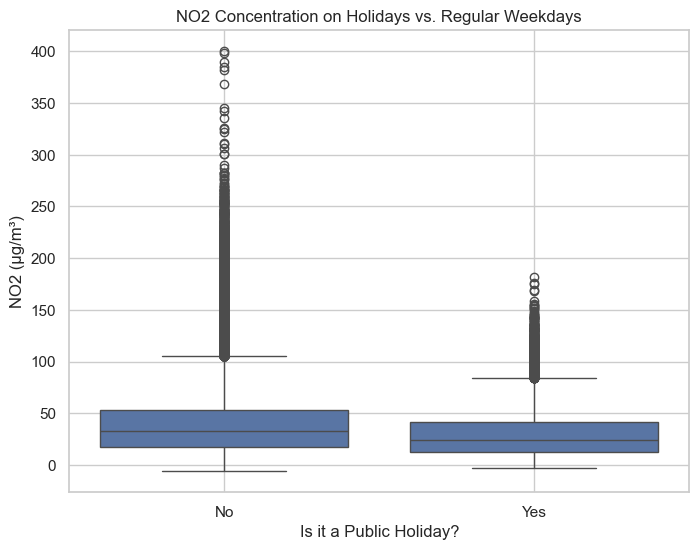

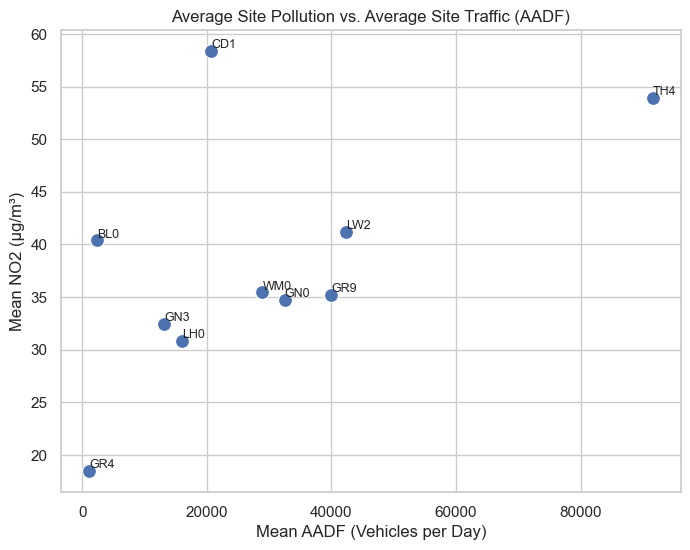

In [56]:
# Impact of Holidays
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='is_holiday', y='NO2')
plt.title('NO2 Concentration on Holidays vs. Regular Weekdays')
plt.xlabel('Is it a Public Holiday?')
plt.xticks([0, 1], ['No', 'Yes'])
plt.ylabel('NO2 (µg/m³)')
plt.grid(True)
plt.show()

# Impact of Average Traffic Volume
site_avg = df.groupby('SiteID').agg(
    avg_no2=('NO2', 'mean'),
    avg_aadf=('aadf_vehicle_count', 'mean')
).dropna()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=site_avg, x='avg_aadf', y='avg_no2', s=100)

for i in range(site_avg.shape[0]):
    plt.text(site_avg.iloc[i]['avg_aadf'], site_avg.iloc[i]['avg_no2'], site_avg.index[i], fontsize=9, ha='left', va='bottom')
plt.title('Average Site Pollution vs. Average Site Traffic (AADF)')
plt.xlabel('Mean AADF (Vehicles per Day)')
plt.ylabel('Mean NO2 (µg/m³)')
plt.grid(True)
plt.show()